<a href="https://colab.research.google.com/github/pedrobslima/projeto-ciencia-de-dados/blob/main/desmatamento2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Ciência de Dados (2)

Pedro Barros de Souza Lima - pbsl@cin.ufpe.br

Pedro Calheiros de Araújo - pca@cin.ufpe.br

Dataset encontrado em: https://dados.gov.br/dados/conjuntos-dados/incendios-em-unidades-de-conservacao-federais

Arquivos importantes: https://www.gov.br/icmbio/pt-br/acesso-a-informacao/dados-abertos/arquivos/sistema-de-analise-e-monitoramento-da-efetividade-de-gestao-samge/dados-do-samge-1-identificacao-e-resultados.xlsx

### **Objetivos:**

1. Escolher uma das colunas dos dados utilizados no projeto 1 para predição (classificação ou regressão) ✅

2. Separar os dados em treinamento, validação e teste ✅

3. Selecionar 4 algoritmos de acordo com a tarefa escolhida no passo 1 ✅

4. Adicionar MLFlow no treinamento dos modelos para rastreamento ✅ 

5. Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação ✅
    1. Selecionar poucos hiper-parâmetros por algoritmo (max. 3) ✅
    2. Selecionar o modelo (algoritmo+valores de hiper-parâmetros) com melhor resultado na métrica de avaliação ✅
    3. Executar o melhor modelo de cada algoritmo no conjunto de teste e selecionar o melhor modelo geral na métrica de avaliação ✅

6. Realizar diagnóstico do melhor modelo geral da etapa 5 e melhorá-lo a partir do diagnóstico ⛔

* Bônus: Utilizar auto-sklearn, clustering para entendimento dos dados ⛔

### Imports

In [ ]:
#!pip install mlflow

#!pip install auto-sklearn

In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import sklearn
from math import log10
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler #, MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from random import randint
import logging
from imblearn.over_sampling import SMOTE

# Classificação
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import graphviz

# Avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bônus
#import autosklearn

### Funções

In [2]:
def analiseTipos(df:pd.DataFrame, feature:str = None):
  '''Para printar uma contagem dos tipos, incluindo valores <NAN>
  Caso o parâmentro "feature" não seja declarado, será feito o .dtypes do dataframe "df"'''
  if(feature):
    print(f'''Num <NAN>: {len(df[df[feature].isna()])}

{df[feature].apply(lambda x: type(x)).value_counts()}''')
  else:
    print(f'Num <NAN>: {len(df[df.isna()])}\n')
    print(df.dtypes)

In [3]:
def getMetrics(test, pred):

  labels = [0,1,2,3,4]
  acc = accuracy_score(test, pred)
  prc = precision_score(test, pred, labels=labels, average='macro')
  rcl = recall_score(test, pred, labels=labels, average='macro')
  f1s = f1_score(test, pred, labels=labels, average='macro')

  return acc, prc, rcl, f1s

In [141]:
def confMatrix(test, pred, display:list|None=None, plot_img:bool=False):
  labels = [0,1,2,3,4]

  #cm = confusion_matrix(test, pred, labels=labels)
  
  fig_cm = plt.figure()
  if(display is not None):
    disp = ConfusionMatrixDisplay.from_predictions(test, pred, ax=plt.gca(), display_labels=display[:len(np.unique(pred))])
  else:
    disp = ConfusionMatrixDisplay.from_predictions(test, pred, ax=plt.gca(), display_labels=labels[:len(np.unique(pred))])

  if(plot_img==False):
    plt.title('Matriz de Confusão')
    return fig_cm
  
  print("Matriz de Confusão:")
  #disp.plot()
  plt.show()

In [5]:
def checkMetrics(test, pred, display:list=None):
    acc, prc, rcl, f1s = getMetrics(test, pred)

    print(f'''Acurácia: {acc:.11f}
Precisão: {prc:.11f}
Recall: {rcl:.11f}
F1-Score: {f1s:.11f}
''')

    confMatrix(test, pred, display, plot_img=True)

In [117]:
def mlflow_log(model, train:list|tuple, valid:list|tuple, test:list|tuple, model_params:dict, model_reg:str, model_tag:str, display:list|tuple=None):
    with mlflow.start_run() as run:
        # accuracy, precision, recall, f1-score 
        train_scores = getMetrics(train[1], model.predict(train[0]))
        valid_scores = getMetrics(valid[1], model.predict(valid[0]))

        test_pred = model.predict(test[0])
        test_scores = getMetrics(test[1], test_pred)
        cmatrix = confMatrix(test[1], test_pred, display=display)

        print(f'''
{str(list(model_params.values())[:-3])}

        \t\tTreinamento\t| Validação\t\t| Teste
Acurácia:\t{train_scores[0]}\t|  {valid_scores[0]}\t|  {test_scores[0]}
Precisão:\t{train_scores[1]}\t|  {valid_scores[1]}\t|  {test_scores[1]}
Recall:  \t{train_scores[2]}\t|  {valid_scores[2]}\t|  {test_scores[2]}
F1-Score:\t{train_scores[3]}\t|  {valid_scores[3]}\t|  {test_scores[3]}
''')
        mlflow.log_params(model_params)
        mlflow.log_metrics({'cross_val_score': max(k_scores_cross[model_tag]), 
                            "train_accuracy": train_scores[0],
                            "train_precision": train_scores[1],
                            "train_recall": train_scores[2],
                            "train_f1_score": train_scores[3],
                            "valid_accuracy": valid_scores[0],
                            "valid_precision": valid_scores[1],
                            "valid_recall": valid_scores[2],
                            "valid_f1_score": valid_scores[3],
                            'test_accuracy': test_scores[0],
                            'test_precision': test_scores[1],
                            'test_recall': test_scores[2],
                            'test_f1_score': test_scores[3]
                            })
        mlflow.set_tag('clf', model_tag)
        mlflow.log_figure(cmatrix, 'conf_matrix.png')
        plt.close(cmatrix)

        run_id = run.info.run_id

        #tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        mlflow.sklearn.log_model(model, "model", registered_model_name=model_reg)

    return run_id

## prep

Coleta dos dados principais:

In [7]:
#PATH = '/content/tabela_de_desmatamento_ucs.xlsx'
PATH = 'tabela_de_desmatamento_ucs.xlsx'

df = pd.read_excel(PATH, sheet_name=0, header=1)
df = df.drop(df.index[-1])
df = df.assign(bioma = "Amazônia")
for b in ['Mata Atlântica', 'Pampa', 'Cerrado', 'Caatinga']: # tirei o pantanal porque dados estavam incompletos
  temp = pd.read_excel(PATH, sheet_name=b, header=1)
  temp = temp.drop(temp.index[-1])
  temp = temp.assign(bioma = b)
  df = pd.concat([df, temp], ignore_index=True)

---
#### Verificação da coluna 'TOTAL' e remoção de registros pré-2008


In [8]:
cols = ['Até 2007', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 'Até 2000', '2001 a 2004', 2006, 2002, 2004]

df.assign(total_check=lambda x: x.loc[:,cols].sum(axis=1))[['unidade de conservação', 'bioma', 'TOTAL', 'total_check']]

,unidade de conservação,bioma,TOTAL,total_check
0,APA do Igarapé Gelado,Amazônia,9146.70,9146.70
1,APA do Tapajós,Amazônia,137537.01,137537.01
2,APA dos Campos de Manicoré,Amazônia,215.43,215.43
3,ARIE Projeto Dinâmica Biológica de Fragmento F...,Amazônia,74.26,74.26
4,ARIE Seringal Nova Esperança,Amazônia,1777.85,1777.85
...,...,...,...,...
316,REBIO Guaribas,Caatinga,20.16,20.16
317,RESEX do Batoque,Caatinga,105.36,105.36
318,RESEX Prainha do Canto Verde,Caatinga,72.90,72.90
319,REVIS da Ararinha Azul,Caatinga,111.72,111.72


Se você for comparar os valores da soma e do TOTAL, pelo pandas vai dizer que alguns não são iguais, mas se compararmos visualmente, claramente não há diferença. Provavelmente é uma diferença na leitura dos floats ou na computação da soma. Não há diferenças relevantes.

De qualquer forma ela será removida porque, ao final do tratamento dos dados, ela não será útil, já que parte dos valores que se somavam para dar o valor em TOTAL foi retirado, ou foi adicionado algum valor no lugar de dados ausentes.

In [9]:
df = df.drop(columns=['Até 2007', '2001 a 2004', 'Até 2000', 2002, 2006, 2004, 'TOTAL'])

---
#### Verificação de Unidades de Conservação (UC) duplicadas

In [10]:
cols = ['unidade de conservação', 'bioma']
#df.loc[:,cols].groupby(by='unidade de conservação').aggregate('count').sort_values(by='bioma', ascending=False).head(18)

UCs repetidas são compostas por 2 biomas. É importante deixá-las como instâncias separadas porque a área desmatada é diferente entre biomas da mesma UC.

In [11]:
df[df['unidade de conservação'] == 'PARNA Cavernas do Peruaçu']

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,bioma
259,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,8.68,NaN,26.68,NaN,75.26,7.09,1.01,0.0,0.00,10.12,12.59,0.00,0.0,0.00,0.0,NaN,Cerrado
303,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,142.74,NaN,86.69,4.96,NaN,241.22,82.60,NaN,78.57,41.40,61.49,13.29,5.1,15.49,0.0,NaN,Caatinga


---
#### Coleta & Integração das Unidades Federativas ao dataset principal
(+ rápida análise + remoção de duplicatas)


In [12]:
#dfid = pd.read_excel('/content/dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]
dfid = pd.read_excel('dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]

Não foi apresentado aqui no código, mas na planilha original, a diferença entre essas duplicatas são apenas o ano do registro, que é importante para dados referentes ao gerenciamento das UCs.

Como nós só precisamos do(s) estado(s) onde estão localizadas, não tem porquê manter essas duplicatas:  

In [13]:
dfid = dfid.drop_duplicates()
df['unidade de conservação'] = df['unidade de conservação'].apply(lambda x: x.upper())
df = pd.merge(df, dfid, how='inner', right_on='Nome da UC', left_on='unidade de conservação').drop(columns=['Nome da UC'])
#df[df['unidade de conservação'] == 'APA DA BACIA DO RIO DESCOBERTO']

---
#### Definição de tipos

In [14]:
df.dtypes

cnuc                       object
unidade de conservação     object
área_ha_uc                float64
2008                      float64
2009                      float64
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2015                      float64
2016                      float64
2017                      float64
2018                      float64
2019                      float64
2020                      float64
2021                      float64
2022                      float64
2023                      float64
bioma                      object
UF                         object
dtype: object

In [15]:
co = ['AL', 'PE', 'PB', 'RN', 'SE', 'CE', 'PI', 'MA', 'BA', # NE  (1) 0-8
      'TO', 'PA', 'AC', 'RR', 'RO', 'AP', 'AM',             # N   (1) 9-15
      'MT', 'MS', 'DF', 'GO',                               # CO  (1) 16-19
      'PR', 'RS', 'SC',                                     # S   (1) 20-22
      'ES', 'RJ', 'MG', 'SP',                               # SE  (1) 23-26
      'AL, PE', 'CE, PI',                     # NE      (2) 27-28
      'BA, TO',                               # NE, N   (2) 29
      'AM, RO', 'AM, PA', 'AM, RR', 'AP, PA', # N       (2) 30-33
      'AM, MT', 'AM, MT, RO',                 # N, CO   (2)(3) 34-35
      'DF, GO',                               # CO      (2) 36
      'MS, PR',                               # CO, S   (2) 37
      'RS, SC',                               # S       (2) 38
      'RJ, SP'                                # SE      (2) 39
      ]

df['UF'] = df['UF'].astype(pd.api.types.CategoricalDtype(categories=co))

Não acho que vale a pena aumentar o número de UCs para que cada instância tenha apenas uma UF relacionada. Elas já foram dividas de acordo com seus biomas, além disso, não temos como relacionar um bioma a um estado exclusivamente porque biomas não respeitam fronteiras artificiais.

In [16]:
df['bioma'] = df['bioma'].astype('category')
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

Criação da coluna "região":

Apenas 4 UCs estão presentes em mais de uma região.

In [17]:
uf2reg = ['NE', 'N', 'CO', 'S', 'SE', 'NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = pd.cut(df.UF.cat.codes, [0, 9, 16, 20, 23, 27, 29, 30, 34, 36, 37, 38, 39, 40], ordered=False, labels=uf2reg, right=False)

# Define and apply arbitrary category order
# Essa ordem foi decidida porque se quiser fazer uma análise de bioma presentes
# nas regiões, por exemplo, Norte e/ou Centro-Oeste, é só especificar o intervalo
# dos índices de ambas as regiões, que também irá incluir UCs presentes em ambas
# ao mesmo tempo, df['região'].cat.categories[1:4] => ['N', 'N, CO', 'CO'],
# ou até df['região'].cat.categories[3:6] => ['N', 'N, CO', 'CO']
co = ['NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = df['região'].astype(pd.api.types.CategoricalDtype(categories=co))

df['região'].value_counts()

região
N        82
NE       57
SE       38
S        27
CO       12
N, CO     2
CO, S     1
NE, N     1
Name: count, dtype: int64

---
####Tratamento de dados ausentes

In [18]:
cols = ['unidade de conservação', 'área_ha_uc', 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 'bioma']
#df[cols].head()

Quantidades de dados nulos por bioma e ano:

In [19]:
dfna = pd.DataFrame(index=df.bioma.cat.categories, columns=range(2008,2024))
dfna = dfna.transform(lambda x: [df.loc[(df.bioma==x.name), col].isna().sum() for col in range(2008,2024)], axis=1)
dfna = dfna.assign(num_total=lambda x: df.bioma.value_counts())
dfna

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,num_total
Amazônia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,87
Caatinga,0,28,0,0,28,0,0,28,0,0,0,0,0,0,0,28,28
Cerrado,0,33,0,33,0,0,0,0,0,0,0,0,0,0,0,33,33
Mata Atlântica,0,70,0,0,70,0,0,70,0,0,0,0,0,0,0,70,70
Pampa,0,2,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2


Colunas NAN por biomas:
* Amazônia:
  * Any NAN: 2023 (25NAN x 62NUM)
  * All NAN:
* Caatinga:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Cerrado:
  * Any NAN: 2009, 2011, 2023
  * All NAN: 2009, 2011, 2023
* Mata Atlântica:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Pampa:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023

In [20]:
df.loc[:,2023].isna().sum() / len(df)

0.7181818181818181

Aproximadamente 72% dos registros de 2023 são nulos, então serão removidos.

In [21]:
df = df.drop(columns=[2023])

Como a maioria das colunas de anos faltantes estão entre colunas com dados declarados, achei melhor que esses dados faltantes fossem substituídos pela média das duas colunas vizinhas, indicando um aumento/diminuição gradual da quantidade de hectares desmatados, ao invés de simplesmente dizer que, por exemplo, não houve desmatamento para todas as UCs do bioma da Pampa no ano de 2009.

In [22]:
cols = [2009, 2012, 2015]
df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols] = df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = [2009, 2011]
df.loc[(df.bioma.cat.codes==2), cols] = df.loc[(df.bioma.cat.codes==2), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = list(range(2008, 2023))

#### Normalização e Discretização

In [23]:
scaler = StandardScaler()
#df_norm = df.loc[:,(['área_ha_uc']+cols)].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1,1)))

df_norm = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
df_norm['área_ha_uc'] = scaler.fit_transform(np.array(df['área_ha_uc']).reshape(-1,1))

colsa = ['área_ha_uc'] + cols

df_norm['bioma'] = df['bioma'].copy()

As colunas normalizadas não seguem distribuição gaussiana.

In [24]:
df_norm.describe()

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,área_ha_uc
count,2.200000e+02,2.200000e+02,2.200000e+02,220.000000,2.200000e+02,2.200000e+02,2.200000e+02,220.000000,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02
mean,8.074349e-18,2.422305e-17,-1.614870e-17,0.000000,-1.211152e-17,-2.018587e-18,-2.018587e-18,0.000000,-8.074349e-18,-8.074349e-18,4.844610e-17,-3.229740e-17,1.614870e-17,-3.229740e-17,-4.844610e-17,3.229740e-17
std,1.002281e+00,1.002281e+00,1.002281e+00,1.002281,1.002281e+00,1.002281e+00,1.002281e+00,1.002281,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00,1.002281e+00
min,-2.411852e-01,-1.950873e-01,-1.719694e-01,-0.288749,-2.751946e-01,-1.832701e-01,-2.469846e-01,-0.177621,-1.953284e-01,-2.357797e-01,-2.178445e-01,-1.956222e-01,-1.944161e-01,-1.799297e-01,-2.000674e-01,-5.286977e-01
25%,-2.411852e-01,-1.950873e-01,-1.719694e-01,-0.288749,-2.751946e-01,-1.832701e-01,-2.469846e-01,-0.177621,-1.953284e-01,-2.357797e-01,-2.178445e-01,-1.956222e-01,-1.944161e-01,-1.799297e-01,-2.000674e-01,-5.080258e-01
50%,-2.345923e-01,-1.866430e-01,-1.622976e-01,-0.285976,-2.698296e-01,-1.807170e-01,-2.463713e-01,-0.176512,-1.936902e-01,-2.350587e-01,-2.170910e-01,-1.920719e-01,-1.926140e-01,-1.797652e-01,-2.000674e-01,-4.038971e-01
75%,-1.362561e-01,-1.401371e-01,-1.173074e-01,-0.201135,-2.033755e-01,-1.491607e-01,-1.896150e-01,-0.142325,-1.554789e-01,-1.878629e-01,-1.851505e-01,-1.606854e-01,-1.596718e-01,-1.577661e-01,-1.757415e-01,-1.263387e-02
max,1.142739e+01,1.148140e+01,1.315629e+01,8.963003,9.307065e+00,1.115757e+01,8.787245e+00,12.182520,1.053878e+01,9.315896e+00,1.064459e+01,9.907319e+00,1.122500e+01,1.160804e+01,8.606931e+00,6.622432e+00


<Axes: >

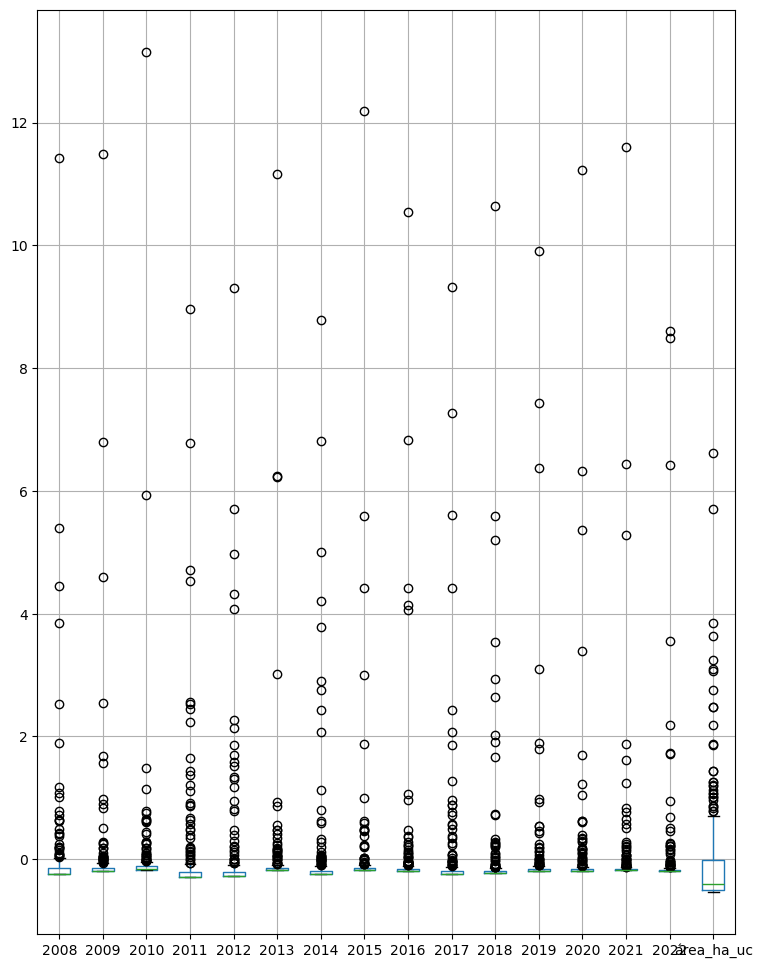

In [25]:
df_norm.boxplot(figsize=(9,12))

Essa versão normalizada do dataset será usada para o treinamento do classificador Support Vector Machine (SVM).

Uma das utilizadas seria a reposição de dados ausentes, que poderiam ser repostos pelo knn-inputer. Porém, pela particularidade da forma em que os dados ausentes estavam presentes, o grupo optou por usar outras técnicas para inputação de dados, tornando o knn-inputer irrelevante, e a normalização sem sentido.

In [26]:
dfd = df.copy()
q1 = df['área_ha_uc'].quantile(q=0.33)
q2 = df['área_ha_uc'].quantile(q=0.67)

dfd = dfd.assign(tamanho_área = 'pequena')
dfd.loc[(dfd['área_ha_uc'] > q1), ['tamanho_área']] = 'médio'
dfd.loc[(dfd['área_ha_uc'] > q2), ['tamanho_área']] = 'grande'
dfd['tamanho_área'] = dfd['tamanho_área'].astype('category')
dfd['tamanho_área'] = dfd['tamanho_área'].cat.codes
dfd.head()

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2017,2018,2019,2020,2021,2022,bioma,UF,região,tamanho_área
0,0000.00.0022,APA DO IGARAPÉ GELADO,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,...,0.00,0.00,9.81,23.75,7.68,14.29,Amazônia,PA,N,1
1,0000.00.0268,APA DO TAPAJÓS,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,...,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,Amazônia,PA,N,0
2,0000.00.3407,APA DOS CAMPOS DE MANICORÉ,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,...,26.83,11.19,40.52,0.00,20.45,29.66,Amazônia,AM,N,1
3,0000.00.0044,ARIE SERINGAL NOVA ESPERANÇA,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,...,61.09,55.34,70.91,57.78,119.10,61.31,Amazônia,AC,N,2
4,0000.00.3131,ESEC ALTO MAUÉS,6.665559e+05,0.00,16.64,31.22,0.00,0.00,0.00,0.00,...,0.00,0.00,45.94,5.56,33.46,145.82,Amazônia,AM,N,0


A discretização também foi um ponto discutido entre a dupla, porém chegamos à conclusão que a discretização não faz sentido para as análises feitas neste projeto, podendo ser útil apenas na 2ª etapa do projeto, onde será feito o uso de classificadores e/ou regressores.

#### Detecção de outrliers e Limpeza de dados

Boxplot dos dados de desmatamento em cada ano. Os valores dos dados não são acumulativos, e sua unidade é Hectare (ha).

In [27]:
df[range(2008,2023)].boxplot(figsize=(9,12))

<Axes: >

Boxplot dos dados modificados. Ao invés de ser os dados puros de desmatamento, são as porcentagens da área desmatada de cada UC, ao longo dos anos. Dados não-acumulativos.

In [28]:
dft = df.copy()
dft.loc[:,range(2008,2023)] = dft.loc[:,range(2008,2023)].apply(lambda x: x/dft['área_ha_uc'])
dft[range(2008,2023)].boxplot(figsize=(9,12))

<Axes: >

Os boxplots apresentados mostram claramente vários outliers presentes no dataset, porém, contrário do que normalmente se pensaria, esses dados são relevantes e não devem ser excluídos do dataset.

As UCs possuem tamanhos muito diferentes, além de que a maioria das UCs não possuem uma área de milhares de hectares, que é o caso de certas UCs localizadas na Amazônia. Portanto, mesmo sendo consideradas como outliers, essas Unidades de Conservação não devem ser retiradas do dataset, pois elas ainda são importantes para a análise dos dados. De qualquer forma, é importante que quem esteja vendo as análises sendo feitas aqui, tenha essa informação em mente.

## Modelos e previsões

* Árvore de Decisão (dtree)
* Random Forest (rforest)
* K-Nearest-Neighbours (knn)
* MultiLayer Perceptron (mlp)

Opções de colunas para previsão:

1. ```2022```: Quantidade de hectares desmatados em 2022 de uma UC (mas talvez esteja indo mais a fundo de processamento de séries temporais)
  * Regressão
  * Classificação (se fizer discretização da coluna)

2. ```bioma```: Bioma a qual uma UC pertence com base nos dados do desmatamento
  * Classificação

#### Manipulações

In [88]:
seed = randint(0, 4294967295)
#seed = 647184138 # melhor seed encontrada até agora
print('Seed:', seed)

Seed: 1014865510


In [89]:
display_labels = ("Amaz", 'Caat', 'Cerr', 'MA', 'Pampa')

In [90]:
df['bioma'].value_counts()

bioma
Amazônia          87
Mata Atlântica    70
Cerrado           33
Caatinga          28
Pampa              2
Name: count, dtype: int64

In [91]:
X = df[colsa]
y = df['bioma'].cat.codes # coluna escolhida

Xc = X.copy()
yc = y.copy()

X.columns = X.columns.astype(str)

normalização:

In [92]:
X_norm = df_norm[colsa]
y_norm = df_norm['bioma'].cat.codes # coluna escolhida

Xc_norm = X_norm.copy()
yc_norm = y_norm.copy()

X_norm.columns = X_norm.columns.astype(str)

split:

In [93]:
TEST_SIZE = 0.3
VALID_SIZE = 0.5 # provavelmente será retirado

In [94]:
X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=seed, shuffle=True)

# Over-Sampling
X_train_imb = pd.concat([X_train_imb, X.loc[y==4,:], X.loc[y==4,:], X.loc[y==4,:]], ignore_index=True)
y_train_imb = pd.concat([y_train_imb, pd.Series([4]*6)], ignore_index=True)

smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_train, y_train = smote.fit_resample(X_train_imb, y_train_imb)

# validation split
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=VALID_SIZE, random_state=seed, shuffle=True)

split (normalizado):

In [95]:
X_train_imb_norm, X_test_norm, y_train_imb_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=TEST_SIZE, random_state=seed, shuffle=True)

# Over-Sampling
X_train_imb_norm = pd.concat([X_train_imb_norm, X_norm.loc[y_norm==4,:], X_norm.loc[y_norm==4,:], X_norm.loc[y_norm==4,:]], ignore_index=True)
y_train_imb_norm = pd.concat([y_train_imb_norm, pd.Series([4]*6)], ignore_index=True)

X_train_norm, y_train_norm = smote.fit_resample(X_train_imb_norm, y_train_imb_norm)

# validation split
X_train_sub_norm, X_valid_norm, y_train_sub_norm, y_valid_norm = train_test_split(X_train_norm, y_train_norm, test_size=VALID_SIZE, random_state=seed, shuffle=True)

Análise rápida:

In [96]:
y_train

0      3
1      1
2      3
3      3
4      0
      ..
280    4
281    4
282    4
283    4
284    4
Length: 285, dtype: int64

In [97]:
y_train.value_counts()

3    57
1    57
0    57
2    57
4    57
Name: count, dtype: int64

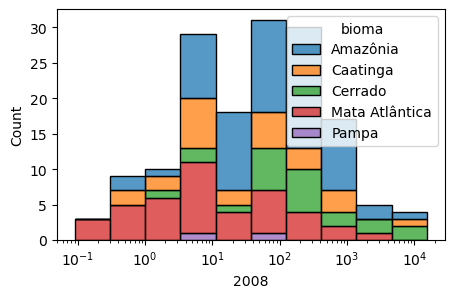

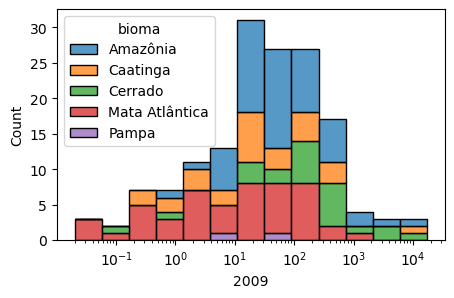

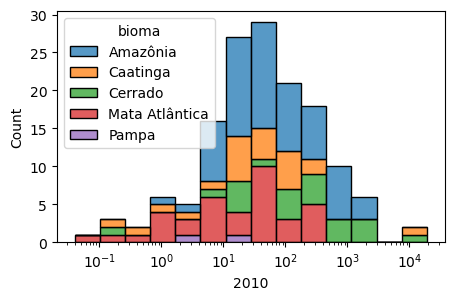

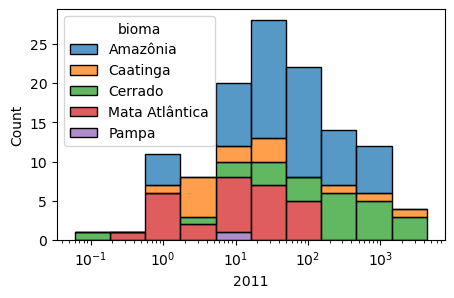

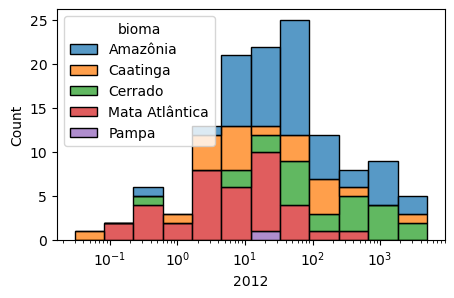

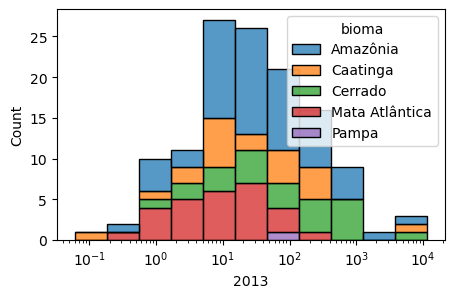

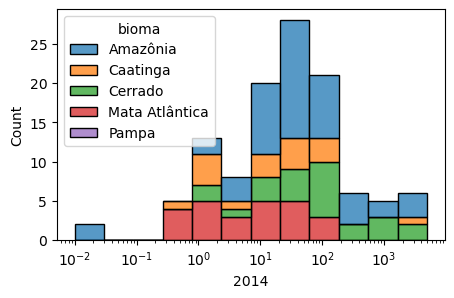

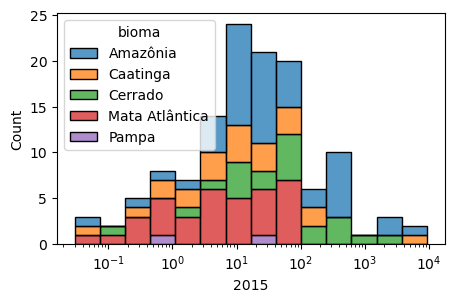

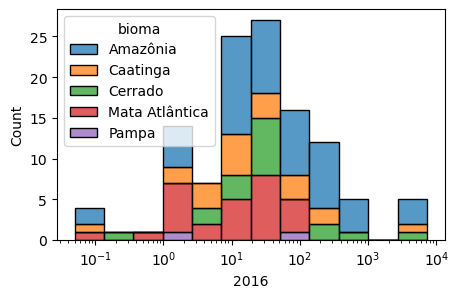

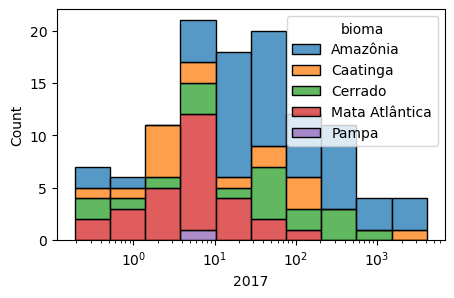

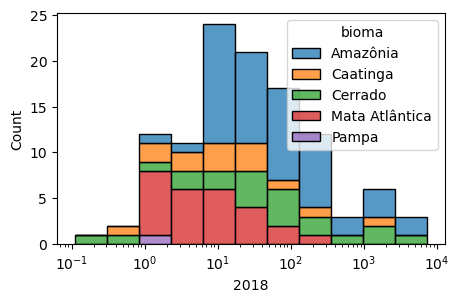

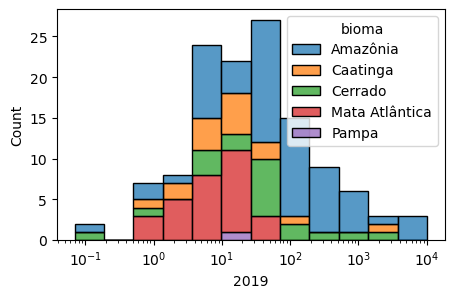

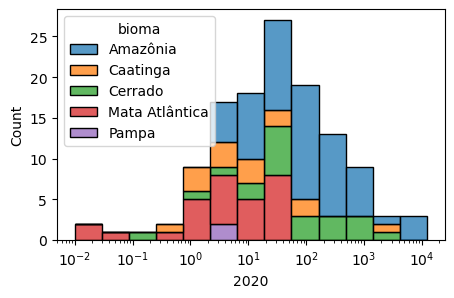

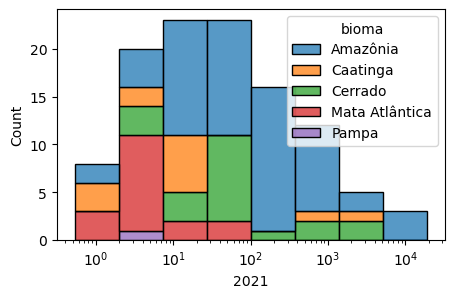

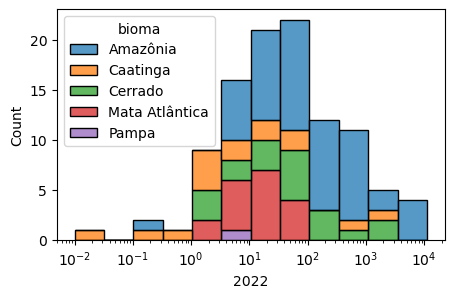

In [98]:
for ano in range(2008, 2023):
    plt.figure(figsize=(5,3))
    sns.histplot(df, x=ano, hue='bioma', log_scale=True, multiple='stack').plot()
    plt.show()

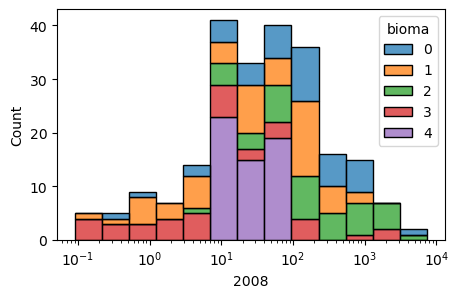

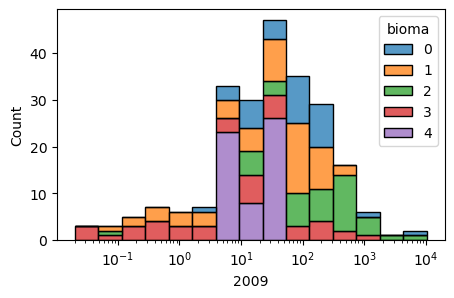

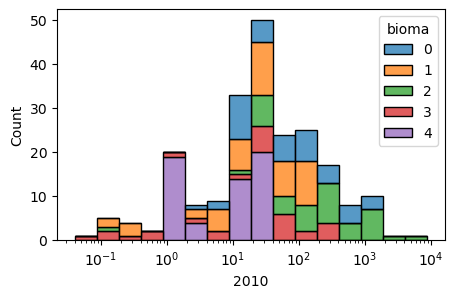

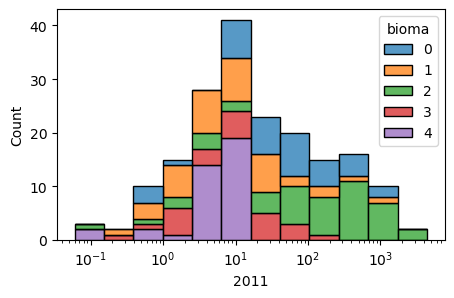

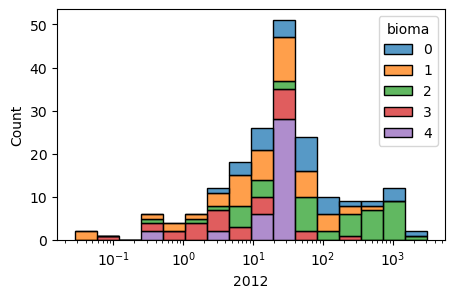

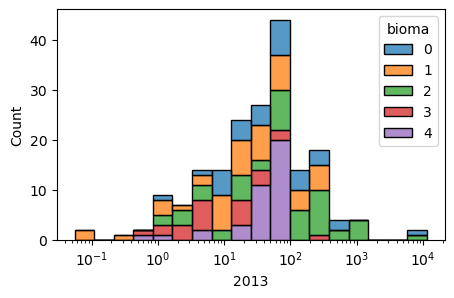

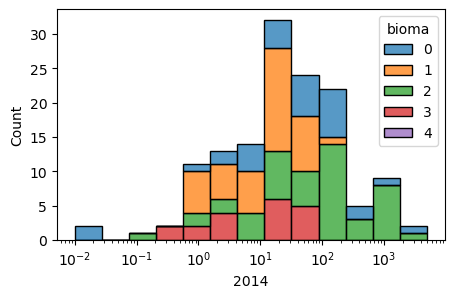

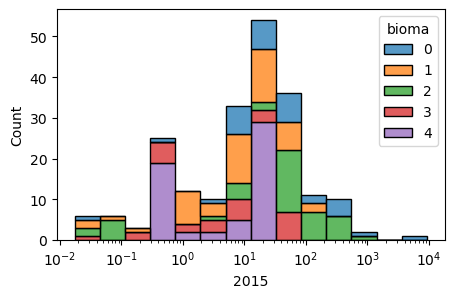

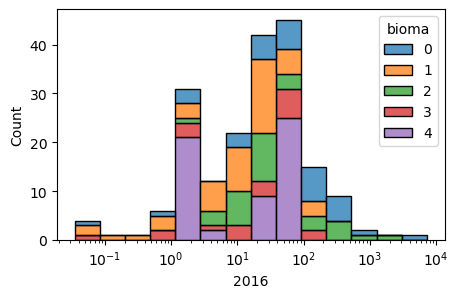

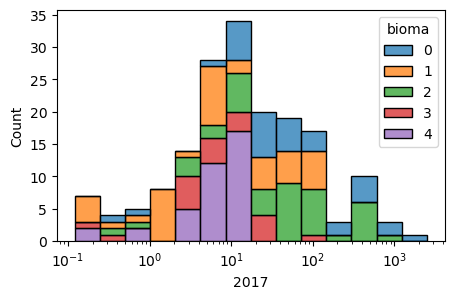

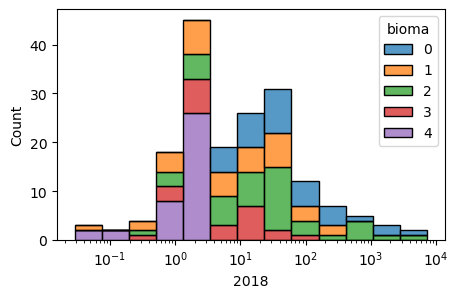

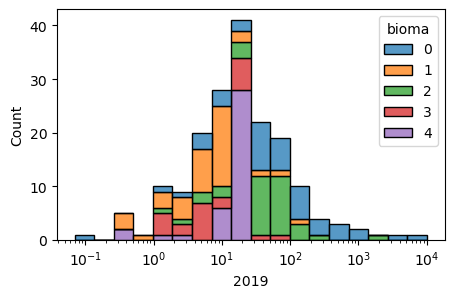

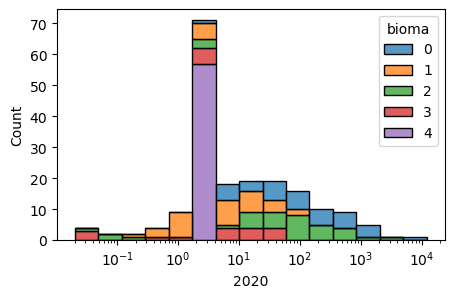

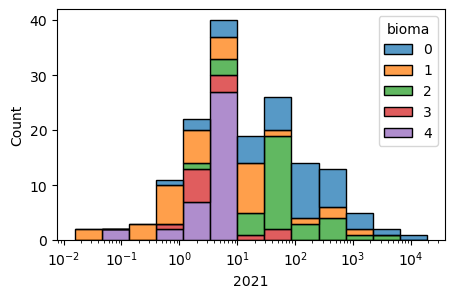

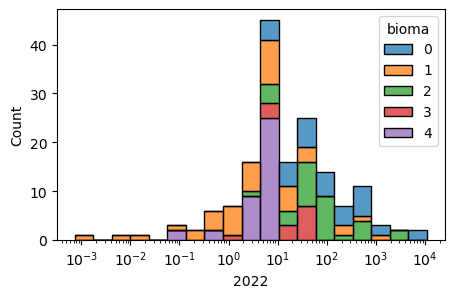

In [99]:
teste = pd.concat([X_train, pd.DataFrame(y_train, columns=['bioma'])], axis=1)

for ano in range(2008, 2023):
    plt.figure(figsize=(5,3))
    sns.histplot(teste, x=str(ano), hue='bioma', log_scale=True, multiple='stack', palette=sns.color_palette()[:5]).plot()
    plt.show()

logging:

In [100]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

k_scores:

In [101]:
k_scores_cross = {}

#### **Escolhendo o experimento**

In [102]:
# set the experiment id
mlflow.set_experiment(experiment_name="Projeto_CD")

<Experiment: artifact_location='file:///c:/Users/pedro/Documents/NOVOdeltadelta/pog/cd/projeto-ciencia-de-dados/mlruns/606761572229167933', creation_time=1720538661155, experiment_id='606761572229167933', last_update_time=1720538661155, lifecycle_stage='active', name='Projeto_CD', tags={}>

### Árvore de Decisão

In [45]:
#construindo o espaco de busca por configuracoes do classificador
criterion = ['entropy', 'gini']
max_depth = [2,5,7,10,12,15,17,20]
min_samples_split = [5,10,15,20,30,40,50,60]

In [56]:
k_scores_cross['dtree'] = []
k_best = -1
tree_best = {'criterion': None, 'max_depth': None, 'min_samples_split': None, 'seed': seed, 'test_size': TEST_SIZE, 'valid_size': VALID_SIZE}

# Validation with MLFlow
for c in criterion:
  for md in max_depth:
    for mss in min_samples_split:
      # training model:
      tmodel = DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_split=mss, random_state=seed)
      scores = cross_val_score(tmodel, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
      k_scores_cross['dtree'].append(scores.mean())
      #tmodel = tmodel.fit(X_train_sub, y_train_sub)

      # Substituindo melhores scores e modelo:
      if(k_scores_cross['dtree'][-1] > k_best):
        k_best = k_scores_cross['dtree'][-1]
        #k_best_id = run.info.run_id
        tree_best['criterion'], tree_best['max_depth'], tree_best['min_samples_split'] = c, md, mss 
        dtree = tmodel

dtree = dtree.fit(X_train, y_train)

In [62]:
# DOT data
#dot_data = tree.export_graphviz(dtree, out_file=None,
#                                feature_names=X.columns,
#                                class_names=display_labels,
#                                filled=True)

# Draw graph
#graph = graphviz.Source(dot_data, format="png")
#graph

In [63]:
tree_best_id = mlflow_log(model=dtree,
                          train=(X_train_sub, y_train_sub),
                          valid=(X_valid, y_valid),
                          test=(X_test, y_test),
                          model_params=tree_best,
                          model_reg='DecisionTree',
                          model_tag='dtree',
                          display=display_labels)

# depois mudar para graphviz
with mlflow.start_run(run_id=tree_best_id):
    fig_tree = plt.figure()
    tree.plot_tree(dtree, feature_names=X.columns, class_names=display_labels, filled = True)
    plt.title('Árvore de Decisão')
    mlflow.log_figure(fig_tree, 'decision_tree.png')
    plt.close(fig_tree)



['gini', 10, 10]

        		Treinamento	| Validação		| Teste
Acurácia:	0.9	|  0.91875	|  0.5272727272727272
Precisão:	0.9052857142857142	|  0.9148387096774193	|  0.5228758169934641
Recall:  	0.9017962719151175	|  0.9200398042503306	|  0.539386189258312
F1-Score:	0.902861933482401	|  0.9141995073891624	|  0.5182857142857143



Registered model 'DecisionTree' already exists. Creating a new version of this model...
Created version '4' of model 'DecisionTree'.


Decision Tree:
    - criterion: gini
    - max_depth: 10
    - min_samples_split: 10

cross_val_score: 0.75625
Acurácia: 0.52727272727
Precisão: 0.52287581699
Recall: 0.53938618926
F1-Score: 0.51828571429

Matriz de Confusão:


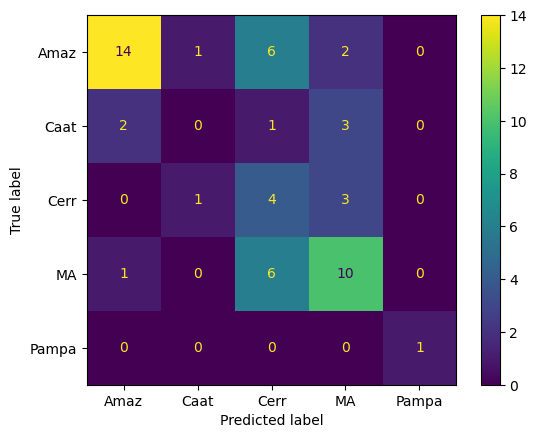

Árvore:


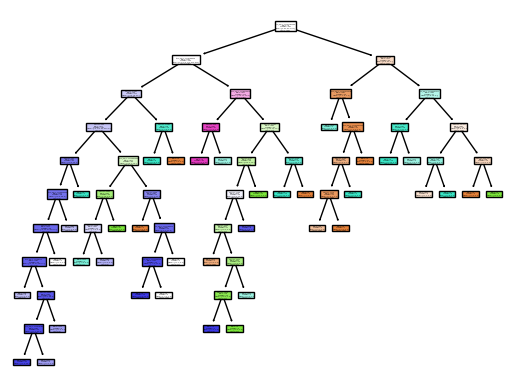

In [64]:
#dtree = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=10, random_state=seed).fit(X_train, y_train)
print(f'''Decision Tree:
    - criterion: {tree_best['criterion']}
    - max_depth: {tree_best['max_depth']}
    - min_samples_split: {tree_best['min_samples_split']}

cross_val_score: {max(k_scores_cross['dtree'])}''')

checkMetrics(y_test, dtree.predict(X_test), display=display_labels)
print('Árvore:')
tree.plot_tree(dtree, feature_names=X.columns, class_names=display_labels, filled = True)
plt.show()

Problemas:
- Overfitting (variância alta) 

### Random Forest

In [103]:
#construindo o espaco de busca por configuracoes do classificador
num_trees = [5, 10, 25, 50]
max_depth = [2,5,7,10,12,15,17,20]
min_samples_split = [5,10,15,20,30,40,50,60]

In [104]:
# Random Forest
k_best = -1
k_scores_cross['rforest'] = []
rforest_best = {'num_trees': None, 'max_depth': None, 'min_samples_split': None, 'seed': seed, 'test_size': TEST_SIZE, 'valid_size': VALID_SIZE}

# Validation with MLFlow
for nt in num_trees:
  for md in max_depth:
    for mss in min_samples_split:
    
      # training model:
      rmodel = RandomForestClassifier(n_estimators=nt, max_depth=md, min_samples_split=mss, random_state=seed)
      scores = cross_val_score(rmodel, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
      k_scores_cross['rforest'].append(scores.mean())

      # Substituindo melhores scores e modelo:
      if(k_scores_cross['rforest'][-1] > k_best):
        k_best = k_scores_cross['rforest'][-1]
        rforest_best['num_trees'], rforest_best['max_depth'], rforest_best['min_samples_split'] = nt, md, mss
        rforest = rmodel
        #k_best_id = run.info.run_id

rforest = rforest.fit(X_train, y_train) 

In [114]:
rforest_best_id = mlflow_log(model=rforest,
                          train=(X_train_sub, y_train_sub),
                          valid=(X_valid, y_valid),
                          test=(X_test, y_test),
                          model_params=rforest_best,
                          model_reg='RandomForest',
                          model_tag='rforest',
                          display=display_labels)

c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[50, 15, 5]

        		Treinamento	| Validação		| Teste
Acurácia:	0.9788732394366197	|  1.0	|  0.6515151515151515
Precisão:	0.98098223615465	|  1.0	|  0.42777777777777776
Recall:  	0.9799404761904762	|  1.0	|  0.407965367965368
F1-Score:	0.9802342646945681	|  1.0	|  0.41148325358851673



Registered model 'RandomForest' already exists. Creating a new version of this model...
Created version '5' of model 'RandomForest'.


Random Forest:
    - num_trees: 50
    - max_depth: 15
    - min_samples_split: 5

cross_val_score: 0.8105263157894737
Acurácia: 0.65151515152
Precisão: 0.42777777778
Recall: 0.40796536797
F1-Score: 0.41148325359

Matriz de Confusão:


c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


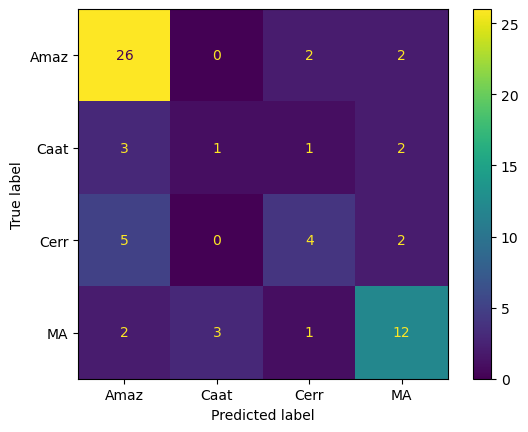

In [121]:
print(f'''Random Forest:
    - num_trees: {rforest_best['num_trees']}
    - max_depth: {rforest_best['max_depth']}
    - min_samples_split: {rforest_best['min_samples_split']}

cross_val_score: {max(k_scores_cross['rforest'])}''')

checkMetrics(y_test, rforest.predict(X_test), display=display_labels)

Problemas:
- Overfitting

### KNN

In [70]:
# KNN
k_best = -1
k_scores_cross['knn'] = []
knn_best = {'k': None, 'seed': seed, 'test_size': TEST_SIZE, 'valid_size': VALID_SIZE}

# Validation with MLFlow
for k in range(2, 20):
    # training model:
    kmodel = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(kmodel, X_train_norm, y_train_norm, cv=5, scoring='accuracy', n_jobs=-1)
    k_scores_cross['knn'].append(scores.mean())

    # Substituindo melhores scores e modelo:
    if(k_scores_cross['knn'][-1] > k_best):
      k_best = k_scores_cross['knn'][-1]
      knn_best['k'] = k
      knn = kmodel
      #k_best_id = run.info.run_id

knn = knn.fit(X_train_norm, y_train_norm)

In [148]:
knn

AttributeError: 'KNeighborsClassifier' object has no attribute 'seed'

In [71]:
knn_best_id = mlflow_log(model=knn,
                          train=(X_train_sub_norm, y_train_sub_norm),
                          valid=(X_valid_norm, y_valid_norm),
                          test=(X_test_norm, y_test_norm),
                          model_params=knn_best,
                          model_reg='KNN',
                          model_tag='knn',
                          display=display_labels)


[4]

        		Treinamento	| Validação		| Teste
Acurácia:	0.775	|  0.79375	|  0.5454545454545454
Precisão:	0.7903605015673982	|  0.8018248807819983	|  0.5019607843137255
Recall:  	0.7857974861370447	|  0.7845458634932319	|  0.6180520034100596
F1-Score:	0.7752307275643919	|  0.7798707410767781	|  0.49246114499311433



K-NearestNeighbours:
    - num_neighbours: 4


Acurácia: 0.68181818182
Precisão: 0.51796536797
Recall: 0.51861471861
F1-Score: 0.49655172414

Matriz de Confusão:


c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


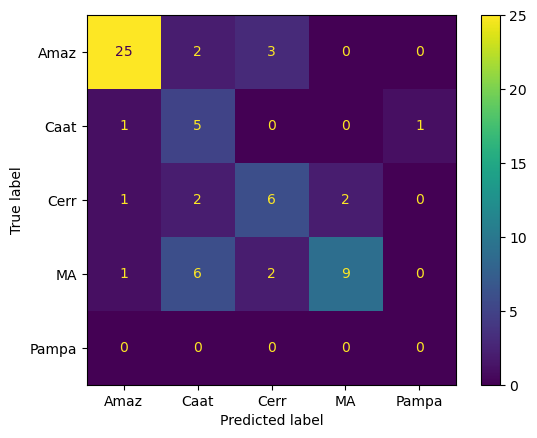

In [150]:
print(f'''K-NearestNeighbours:
    - num_neighbours: {knn_best['k']}

cross_val_score: {max(k_scores_cross['knn'])}''')

checkMetrics(y_test_norm, knn.predict(X_test_norm), display=display_labels)

Problemas:
- Overfitting

### MLP

In [123]:
#construindo o espaco de busca por configuracoes do classificador
learning_rate = [0.001, 0.005, 0.01, 0.05]
alpha = [0, 0.005, 0.01, 0.05, 0.1]
early_stopping = [True, False]
MAX_ITER = 500

In [124]:
# MLP
k_best = -1
k_scores_cross['mlp'] = []
mlp_best = {'learning_rate': None, 'alpha': None, 'early_stopping': None, 'max_iter': MAX_ITER, 'seed': seed, 'test_size': TEST_SIZE, 'valid_size': VALID_SIZE}

# Validation with MLFlow
for lr in learning_rate:
  for a in alpha:
    for es in early_stopping:
    
      # training model:
      mmodel = MLPClassifier(learning_rate_init=lr, alpha=a, early_stopping=es, random_state=seed, max_iter=MAX_ITER)
      scores = cross_val_score(mmodel, X_train_norm, y_train_norm, cv=5, scoring='accuracy', n_jobs=-1)
      k_scores_cross['mlp'].append(scores.mean())

      # Substituindo melhores scores e modelo:
      if(k_scores_cross['mlp'][-1] > k_best):
        k_best = k_scores_cross['mlp'][-1]
        mlp_best['learning_rate'], mlp_best['alpha'], mlp_best['early_stopping'] = lr, a, es
        mlp = mmodel
        #k_best_id = run.info.run_id

mlp = mlp.fit(X_train_norm, y_train_norm) 

In [144]:
mlp_best_id = mlflow_log(model=mlp,
                          train=(X_train_sub_norm, y_train_sub_norm),
                          valid=(X_valid_norm, y_valid_norm),
                          test=(X_test_norm, y_test_norm),
                          model_params=mlp_best,
                          model_reg='MultiLayerPerceptron',
                          model_tag='mlp',
                          display=display_labels)

with mlflow.start_run(run_id=mlp_best_id):
    fig_lc = plt.figure()
    plt.axes(sns.lineplot(y=mlp.loss_curve_, x=range(1, mlp.n_iter_ + 1)))
    plt.title('Curva da Função de Perda')
    mlflow.log_figure(fig_lc, 'loss_curve.png')
    plt.close(fig_lc)

c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[0.005, 0, False, 500]

        		Treinamento	| Validação		| Teste
Acurácia:	0.7112676056338029	|  0.6783216783216783	|  0.6060606060606061
Precisão:	0.8132364337687384	|  0.7928422140984455	|  0.41039426523297495
Recall:  	0.7123809523809523	|  0.6855896900034831	|  0.3905916305916306
F1-Score:	0.7294924517729308	|  0.6983389925438442	|  0.3992573910606697



Registered model 'MultiLayerPerceptron' already exists. Creating a new version of this model...
Created version '4' of model 'MultiLayerPerceptron'.


MultiLayer Perceptron:
    - learning_rate: 0.005
    - alpha: 0
    - early_stopping: False
    - max_iter: 500

cross_val_score: 0.6807017543859649
Acurácia: 0.60606060606
Precisão: 0.41039426523
Recall: 0.39059163059
F1-Score: 0.39925739106

Matriz de Confusão:


c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


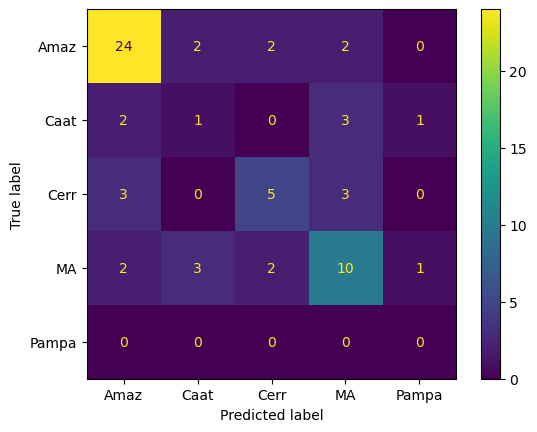

Loss Curve:


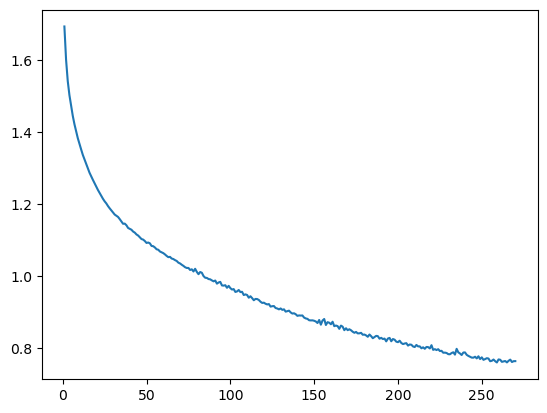

In [146]:
print(f'''MultiLayer Perceptron:
    - learning_rate: {mlp_best['learning_rate']}
    - alpha: {mlp_best['alpha']}
    - early_stopping: {mlp_best['early_stopping']}
    - max_iter: {mlp_best['max_iter']}

cross_val_score: {max(k_scores_cross['mlp'])}''')

checkMetrics(y_test_norm, mlp.predict(X_test_norm), display=display_labels)

print("Loss Curve:")
sns.lineplot(y=mlp.loss_curve_, x=range(1, mlp.n_iter_ + 1)).plot()
plt.show()

Obs.:
- Aumentei o número de max_iter do MLP (V2), só para ver o que aconteceria em uma situação já de overfitting. As métricas de treinamento caíram muito, é como se tivesse desenvolvido um underfitting, e tivesse substituído o overfitting (ou os dois também podem ter aparecido juntos, mas dada a variância do modelo, não tenho muita certeza disso)

## Análises

- Todos os modelos apresentaram Over-Fitting, mas apesar disso, as arquiteturas Random Forest e MLP conseguem classificar bem instâncias da Mata Atlântica e da Amazônia.

- Talvez devido ao número pequeno de instâncias no conjunto de teste, eu não tenha uma certeza maior, mas KNN e MLP conseguem classificar instâncias da Caatinga até que bem

- O Over-Sampling de "Pampa" talvez tenha prejudicado um pouco o desempenho dos modelos, pois eles agora também não conseguem diferenciar a Pampa dos outros biomas

- Depois de alguns testes, as MLPs e as Random Forests seguem sendo as melhores, ficando pau-a-pau nas métricas de teste. A Random Forest tá com Over-Fitting pesado, enquanto a MLP tá com Under-Fitting.
    - (Talvez a Random Forest tenha mais potencial) 

Como tanto a Random Forest como o MLP têm sido os melhores modelos, acho que vou tentar primeiro resolver o overfitting da random forest e, se n surtir efeito, vou tentar resolver o underfitting do MLP

**Random Forest**: 
1. Vou tentar primeiro treinar um modelo menos complexo, alterando os hiperparâmetros usados para a validação cruzada 
    - diminuir num_trees e max_depth 
    - aumentar min_samples_split 

## (resto)

In [212]:
#with mlflow.start_run(run_id=knn_best_id):
#    cmatrix = confMatrix(y_test_norm, knn.predict(X_test_norm), display=display_labels)
#    mlflow.log_figure(cmatrix, 'conf_matrix.png')

In [249]:
'''# Create an instance of a PandasDataset
mltrain_set = mlflow.data.from_pandas(
    pd.concat([X_train, pd.DataFrame(y_train, columns=['bioma'])], axis=1), name="desmatamento_ucs", targets="bioma"
)
mltest_set = mlflow.data.from_pandas(
    pd.concat([X_test, pd.DataFrame(y_test, columns=['bioma'])], axis=1), name="desmatamento_ucs", targets="bioma"
)
mltrain_set_norm = mlflow.data.from_pandas(
    pd.concat([X_train, pd.DataFrame(y_train_norm, columns=['bioma'])], axis=1), name="desmatamento_ucs", targets="bioma"
)
mltest_set_norm = mlflow.data.from_pandas(
    pd.concat([X_test_norm, pd.DataFrame(y_test_norm, columns=['bioma'])], axis=1), name="desmatamento_ucs", targets="bioma"
)'''

In [247]:
#with mlflow.start_run(run_id=tree_best_id):
    #mlflow.log_input(dataset, "testing")
    #mlflow.log_input(pd.concat([X_test, pd.DataFrame(y_test, columns=['bioma'])], axis=1), "Test")

c:\Users\pedro\miniconda3\envs\mainPy\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
